# 1. 데이터 불러오기

In [7]:
# uv add yfinance 
import yfinance as yf 
from datetime import date, timedelta 

year = 5
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = today - timedelta(days=365*year)

print(start_date, end_date)

data = yf.download(
    tickers = "009450.KS",
    start = start_date,
    end = end_date
)
data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_14660\4076130856.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed

2020-09-09 2025-09-08


Price,Close,High,Low,Open,Volume
Ticker,009450.KS,009450.KS,009450.KS,009450.KS,009450.KS
Date,,,,,
2020-09-09,54533.324219,55294.696983,53391.265073,55104.353792,154018
2020-09-10,57102.957031,58816.045742,55009.181940,55389.868320,384979
2020-09-11,57293.304688,58054.677507,55389.872638,56531.931868,153445
2020-09-14,55865.726562,57293.300495,55580.211776,57293.300495,125104
2020-09-15,56246.414062,56531.928855,54438.153712,55865.727673,107441


In [8]:
# 멀티컬럼 제거하기 
data.columns = data.columns.droplevel(1)
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-09-09,54533.324219,55294.696983,53391.265073,55104.353792,154018
2020-09-10,57102.957031,58816.045742,55009.181940,55389.868320,384979
2020-09-11,57293.304688,58054.677507,55389.872638,56531.931868,153445
2020-09-14,55865.726562,57293.300495,55580.211776,57293.300495,125104
2020-09-15,56246.414062,56531.928855,54438.153712,55865.727673,107441


In [9]:
data = data[["Close"]]
data.head()

Price,Close
Date,
2020-09-09,54533.324219
2020-09-10,57102.957031
2020-09-11,57293.304688
2020-09-14,55865.726562
2020-09-15,56246.414062


In [10]:
# scikit-learn pandas matplotlib 
# CUDA를 사용하기 위한 torch 설치 *

In [11]:
import torch
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.8.0+cu126
cuda


# 2. 데이터 분할

In [ ]:
N = len(data)
test_ratio = 0.2 
val_ratio = 0.1

test_size = int(N * test_ratio)
val_size = int(N * val_ratio)
train_size = N - val_size - test_size

# 시계열 데이터는 데이터 사이의 순서가 있으므로 다음과 같이 분할한다
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:(train_size+val_size)]
test_data = data.iloc[(train_size+val_size):]

print(f"Train Data: {train_data.shape}, Val Data: {val_data.shape}, Test Data: {test_data.shape}")

Train Data: (857, 1), Val Data: (122, 1), Test Data: (244, 1)


# 3. 데이터 스케일러 적용

In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_a = pd.DataFrame([50, 100, 150]) # 예상 결과 0, 0.5, 1
data_b = pd.DataFrame([0, 50, 100, 150, 200]) # 예상 결과 -0.5, 0, 0.5, 1, 1.5
scaler_a = scaler.fit_transform(data_a.values)
scaler_b = scaler.transform(data_b.values)
print(scaler_a)
print(scaler_b)

[[0. ]
 [0.5]
 [1. ]]
[[-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]
 [ 1.5]]


In [13]:
from sklearn.preprocessing import MinMaxScaler
# 질문1. MinMaxScaler는 무엇일까?  : 각 값간의 거리 비율을 유지한 상태에서 최대 최소 값을 1 0 으로 축소한다
# 질문2. 스케일러를 사용할 때 반드시 주의해야할 점은 무엇일까? : val, test 데이터는 스케일러에 포함하지 말 것

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values) # train의 스케일링 기준울 기억 이후 val, test 로 평가할 떄 사용
val_scaled = scaler.transform(val_data.values)      
test_scaled = scaler.transform(test_data.values)    

print(f"train_scaled: {train_scaled.dtype}")
print(f"val_scaled: {val_scaled.dtype}")
print(f"test_scaled: {test_scaled.dtype}")

print(f"Scale 범위: {scaler.data_min_}, {scaler.data_max_}")

train_scaled: float64
val_scaled: float64
test_scaled: float64
Scale 범위: [32080.44335938], [74072.0234375]


# 4. 학습 데이터

In [14]:
print(train_scaled.shape)

(857, 1)


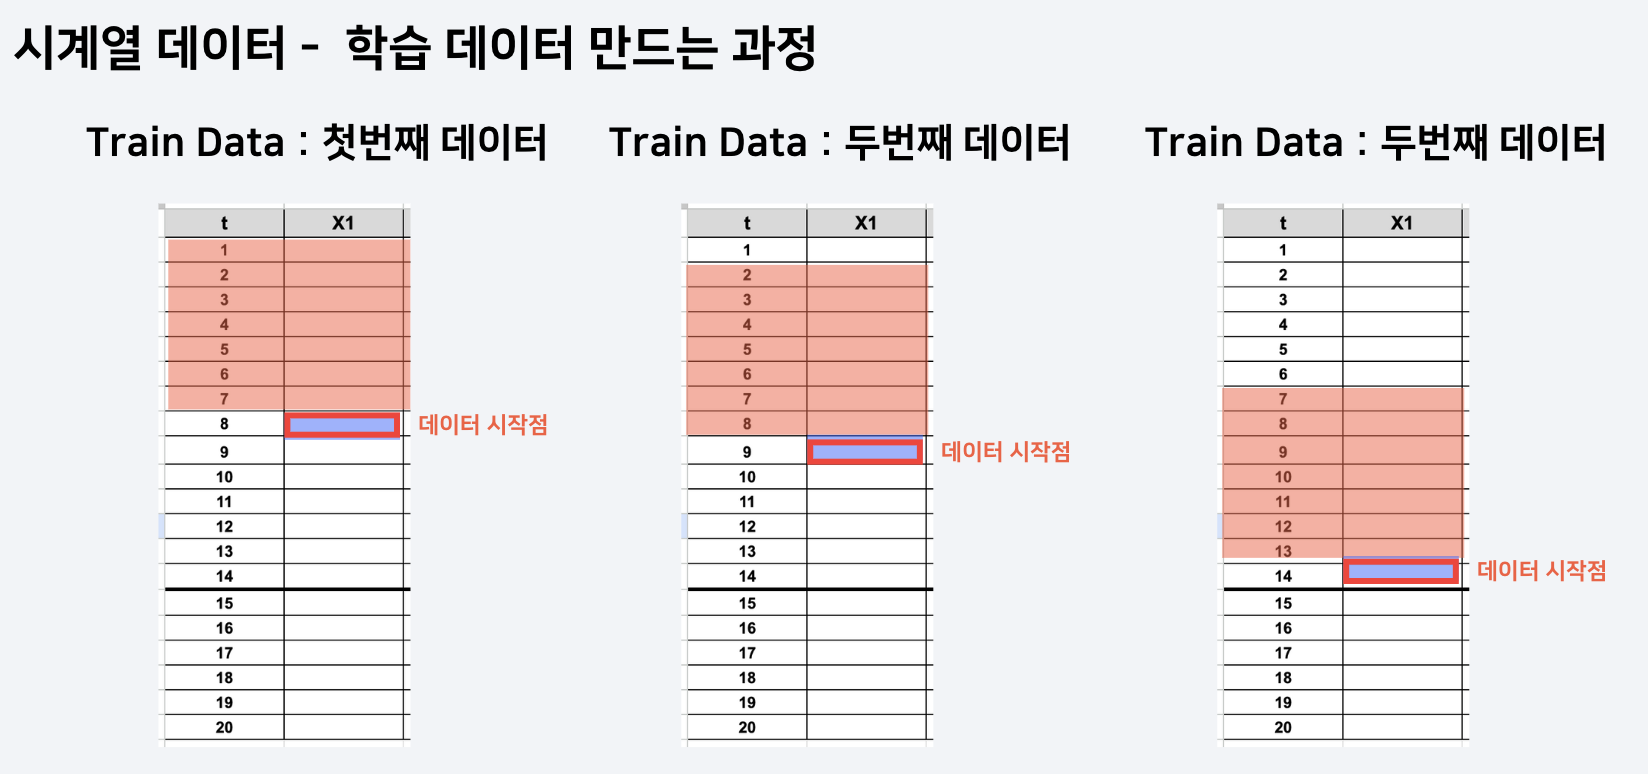

In [29]:
import numpy as np 
# 질문 1. Window가 무엇을 의미하는지 설명할 수 있다. 
# 질문 2. train data가 몇 개 나오는지 설명할 수 있다. > 전체 데이터 - 윈도우 사이즈
def make_dataset(data, window):
    dataX = []
    datay = []

    for i in range(0, data.shape[0] - window):
        x = data[i:(i + window), :]
        y = data[(i + window), [-1]]
        
        dataX.append(x)
        datay.append(y)
    
    return np.array(dataX), np.array(datay)

window = 60
X_train, y_train = make_dataset(train_scaled, window)
# val_scaled의 X, y를 만들기 위해서는 train_scaled에서 맨 뒤에서 window만큼 가져와야 한다. 
X_val, y_val = make_dataset(np.concatenate([train_scaled[-window:], val_scaled]), window)
X_test, y_test = make_dataset(np.concatenate([val_scaled[-window:], test_scaled]), window)

print(X_train.shape, y_train.shape)

(797, 60, 1) (797, 1)


In [26]:
import numpy as np

a = np.array([[1, 2], [3, 4]])
b = np.array([[7, 8], [9, 10], [11, 12]])

print(np.concatenate((a, b), axis=0))

[[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]
 [11 12]]


In [27]:
import numpy as np
test_data = np.array([[1.0, 2.0]])
print(test_data[0])
print(test_data[0, [-1]])

[1. 2.]
[2.]


# 5. DataLoader 만들기

In [30]:
import torch

X_train_ts = torch.FloatTensor(X_train)
y_train_ts = torch.FloatTensor(y_train)
X_val_ts = torch.FloatTensor(X_val)
y_val_ts = torch.FloatTensor(y_val)
X_test_ts = torch.FloatTensor(X_test)
y_test_ts = torch.FloatTensor(X_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_ts, y_train_ts)
val_dataset = TensorDataset(X_val_ts, y_val_ts)
test_dataset = TensorDataset(X_test_ts, y_test_ts)

print(len(train_dataset))
print(train_dataset[0])

797
(tensor([[0.5347],
        [0.5959],
        [0.6004],
        [0.5664],
        [0.5755],
        [0.5664],
        [0.5143],
        [0.5166],
        [0.4758],
        [0.4576],
        [0.4735],
        [0.4372],
        [0.3806],
        [0.4395],
        [0.4304],
        [0.4848],
        [0.4916],
        [0.4848],
        [0.5120],
        [0.5188],
        [0.5188],
        [0.4871],
        [0.4780],
        [0.4576],
        [0.4599],
        [0.4667],
        [0.4894],
        [0.4667],
        [0.4644],
        [0.4146],
        [0.4214],
        [0.4395],
        [0.4372],
        [0.4372],
        [0.4440],
        [0.4440],
        [0.4327],
        [0.4418],
        [0.4599],
        [0.5007],
        [0.5664],
        [0.5279],
        [0.4894],
        [0.4894],
        [0.4871],
        [0.4667],
        [0.4690],
        [0.4871],
        [0.4871],
        [0.4780],
        [0.4939],
        [0.4984],
        [0.4690],
        [0.4531],
        [0.4418],
     

In [ ]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 6. 학습하기

In [ ]:
from torchvision.models.resnet import resnet34
model = resnet34()
model

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

In [ ]:
import torch.nn as nn
from torch.optim.adam import Adam

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

X_train = X_train.to(device)
y_train = y_train.to(device)
model = model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epoches = 10
criterion = nn.MSELoss()

step = 0
for epoch in range(epoches):
    for data, label in train_dataloader:
        optim.zero_grad()

        y_pred = model(X_train)

        loss = criterion(y_pred, y_train.view(-1,1))
        loss.backward()
        optim.step()

        # tensorboard에 데이터 추가
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1

    print(f"{epoch} : loss : {loss.item()}")